In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, RobustScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer


In [36]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

In [37]:
x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)

In [38]:
x_train_imputed['FR_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['FR_WINDPOW']))
x_train_imputed['DE_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['DE_WINDPOW']))

x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()

x_train_imputed['FR_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_RESIDUAL_LOAD'].cumsum()
x_train_imputed['DE_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_RESIDUAL_LOAD'].cumsum()

x_train_imputed['FR_NON_RENEWABLE'] = x_train_imputed['FR_COAL']+ x_train_imputed['FR_GAS'] + x_train_imputed['FR_NUCLEAR']
x_train_imputed['FR_RENEWABLE'] = x_train_imputed['FR_HYDRO']+ x_train_imputed['FR_SOLAR'] + x_train_imputed['FR_WINDPOW']

x_train_imputed['DE_NON_RENEWABLE'] = x_train_imputed['DE_COAL']+ x_train_imputed['DE_GAS'] + x_train_imputed['DE_NUCLEAR'] + x_train_imputed['DE_LIGNITE']
x_train_imputed['DE_RENEWABLE'] = x_train_imputed['DE_HYDRO']+ x_train_imputed['DE_SOLAR'] + x_train_imputed['DE_WINDPOW']

x_train_imputed['EXCESS_PROD_FR'] = x_train_imputed['FR_NON_RENEWABLE']+x_train_imputed['FR_RENEWABLE'] - x_train_imputed['FR_CONSUMPTION']- x_train_imputed['FR_NET_EXPORT']
x_train_imputed['EXCESS_PROD_DE'] =  x_train_imputed['DE_NON_RENEWABLE']+x_train_imputed['DE_RENEWABLE'] - x_train_imputed['DE_CONSUMPTION']- x_train_imputed['DE_NET_EXPORT']

x_train_imputed.drop(['ID', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_TEMP'], axis = 1, inplace = True)

y_train.drop('ID', axis = 1, inplace = True)

In [39]:
columns_to_exclude = ['DAY_ID', 'COUNTRY_FR', 'COUNTRY_DE']

columns_to_standardize = [col for col in x_train_imputed.columns if col not in columns_to_exclude]
scaler = RobustScaler()
x_train_imputed[columns_to_standardize] = scaler.fit_transform(x_train_imputed[columns_to_standardize])

In [40]:
x_train_imputed.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,FR_WIND_SQR,DE_WIND_SQR,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_RESIDUAL_LOAD_cumsum,DE_RESIDUAL_LOAD_cumsum,FR_NON_RENEWABLE,FR_RENEWABLE,DE_NON_RENEWABLE,DE_RENEWABLE,EXCESS_PROD_FR,EXCESS_PROD_DE
0,206.0,-0.153169,-0.024349,-0.317882,0.317882,0.747170,0.364807,-0.236271,-0.363153,0.748676,2.044066,1.176167,0.235238,0.764139,0.100129,-0.057919,0.406017,-0.361743,-0.179808,0.998015,0.454808,0.013084,0.067211,-0.491351,-0.444335,-0.072388,-0.856851,0.254140,0.055699,-0.050354,0.0,1.0,-0.083553,0.0,0.609263,0.262771,0.068397,0.320652,0.309630,0.062073,0.936700,0.370749,0.167443,0.857402
1,501.0,-0.395487,-0.445611,0.070134,-0.070134,-0.216353,-0.743584,-0.446996,0.131324,0.057886,0.008206,-0.089466,-0.455029,-1.691607,-1.353957,0.939921,1.589620,0.041892,-0.074392,-0.005664,-0.524150,-0.610401,-1.064641,-0.798040,1.375466,0.678439,0.414144,-0.513269,-0.014732,-0.485197,0.0,1.0,-0.083553,0.0,-0.126516,-0.582892,-0.383997,-0.428128,-0.623853,0.711096,-0.547064,0.549790,0.647884,-0.052881
2,687.0,1.081811,1.735408,0.762812,-0.762812,-0.250638,-1.078921,1.274725,1.439705,1.379276,2.989941,-0.275166,0.623781,-1.705218,0.774599,-0.702107,-0.558231,-0.155657,-0.096429,0.581261,1.134777,2.032405,-0.259342,-0.143242,0.517002,0.448238,0.622926,0.405551,0.618495,0.134481,0.0,1.0,-0.083553,0.0,-0.152697,-0.838742,1.533596,0.840742,1.764679,-0.463958,0.842637,-1.079763,1.357823,-0.214533
3,720.0,-1.396994,-0.332795,-0.472609,0.472609,-0.002418,0.286022,-0.199434,-0.047943,-0.930450,-0.038039,-0.437881,0.991946,-0.102796,-0.919365,0.815087,-0.002293,0.060971,0.233989,-2.019570,-1.286928,-0.436306,-0.931631,-0.421469,-0.215074,-0.040701,0.341182,0.694389,-0.326954,0.908945,1.0,0.0,0.519131,0.0,0.036852,0.202660,-0.257675,-1.011556,-0.491825,0.669601,-0.991913,0.208618,-0.024410,-0.552880
4,818.0,-0.222260,-0.163001,-0.529307,0.529307,0.522589,0.545598,-0.396447,-0.384065,0.948180,0.951963,-0.351314,-0.447460,0.086633,0.367846,0.255233,0.093327,-0.513012,-0.371662,0.828980,0.402080,-0.055809,-0.323762,-0.302547,-0.678254,-0.564396,0.563408,0.181921,1.330891,2.281802,0.0,1.0,-0.083553,0.0,0.437765,0.400707,0.018409,0.280322,0.222925,-0.980463,0.680754,-0.540847,-0.749346,0.055438


# TRY SPLITTING THE DATA SET INTO FR AND DE

In [41]:
fr_x_train = x_train_imputed[x_train_imputed['COUNTRY_FR'] == 1]
de_x_train = x_train_imputed[x_train_imputed['COUNTRY_DE'] == 1]
y_train_fr = y_train[x_train_imputed['COUNTRY_FR'] == 1]
y_train_de = y_train[x_train_imputed['COUNTRY_DE'] == 1]

In [42]:
fr_x_train.sort_values('DAY_ID', inplace = True)
de_x_train.sort_values('DAY_ID', inplace = True)
y_train_fr = y_train_fr.loc[fr_x_train.index]
y_train_de = y_train_de.loc[de_x_train.index]

/var/folders/th/kg0hx12n5z33hc_fch1zys_40000gn/T/ipykernel_58043/4160478158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr_x_train.sort_values('DAY_ID', inplace = True)
/var/folders/th/kg0hx12n5z33hc_fch1zys_40000gn/T/ipykernel_58043/4160478158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_x_train.sort_values('DAY_ID', inplace = True)


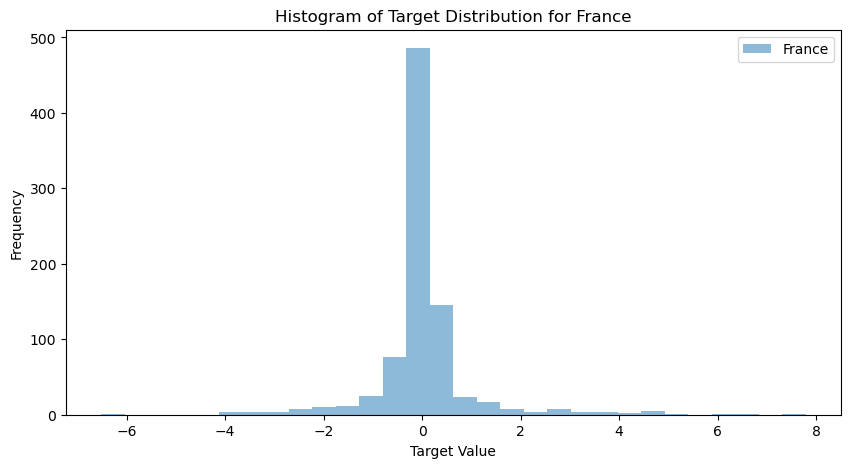

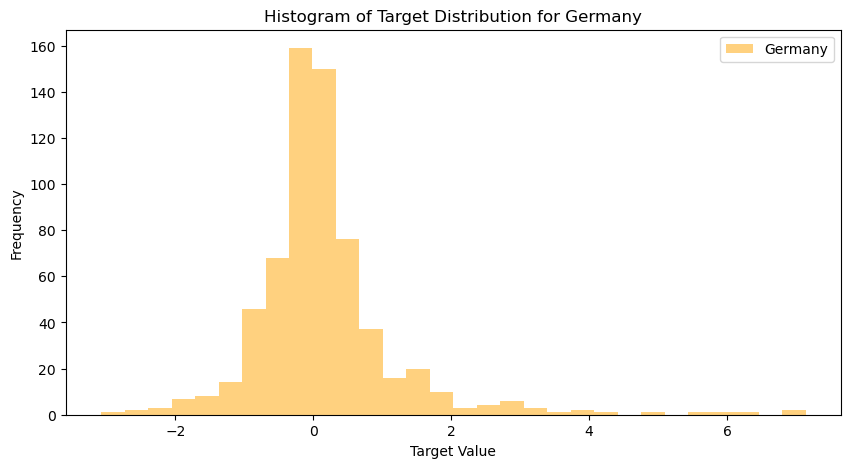

In [43]:
# For the French dataset
plt.figure(figsize=(10, 5))
plt.hist(y_train_fr['TARGET'], bins=30, alpha=0.5, label='France')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Histogram of Target Distribution for France')
plt.legend(loc='upper right')
plt.show()

# For the German dataset
plt.figure(figsize=(10, 5))
plt.hist(y_train_de['TARGET'], bins=30, alpha=0.5, color='orange', label='Germany')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Histogram of Target Distribution for Germany')
plt.legend(loc='upper right')
plt.show()


# TRY RANDOM FOREST ON THE ENTIRE DATA SET

In [44]:
x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)


x_train_imputed

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
0,1054.0,206.0,0.210099,-0.427458,-0.606523,0.606523,0.789557,0.692860,-0.789557,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.0,1.0
1,2049.0,501.0,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0.0,1.0
2,1924.0,687.0,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0.0,1.0
3,297.0,720.0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1.0,0.0
4,1101.0,818.0,0.143807,-0.617038,-0.924990,0.924990,0.471847,0.990324,-0.471847,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459.0,809.0,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,1.810665,1.388269,0.359723,-0.294001,-0.470809,1.708814,0.207266,0.712492,-1.325306,-0.855249,-0.057214,2.968535,0.790548,1.547782,0.509514,-0.077656,0.890049,0.260822,0.520315,-0.460030,-0.238427,0.876984,0.819520,1.320373,1.0,0.0
1490,1674.0,887.0,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,1.972779,1.558300,0.561356,0.230746,-0.341147,2.957114,0.217922,0.926279,-1.222781,-0.923261,0.198857,0.789618,0.917482,1.358927,1.666252,-0.142641,0.539836,0.509007,0.838269,-1.079079,-1.071237,0.932633,-0.085690,0.356356,0.0,1.0
1491,748.0,1083.0,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,2.108764,1.866399,1.072553,-0.180117,0.037892,0.277630,-1.833866,-0.964588,-0.626731,0.196789,-0.981718,0.303324,0.211422,1.493870,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,1.0,0.0
1492,1454.0,1133.0,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,-0.003973,0.869742,-0.436935,-0.772801,-0.288150,1.447245,0.107706,-0.196405,0.619473,0.918251,0.378080,-0.973969,-0.828580,-0.137667,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,0.0,1.0


In [45]:
x_train_imputed['FR_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['FR_WINDPOW']))
x_train_imputed['DE_WIND_SQR'] = np.sqrt(np.maximum(0, x_train_imputed['DE_WINDPOW']))

x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()

x_train_imputed['FR_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_RESIDUAL_LOAD'].cumsum()
x_train_imputed['DE_RESIDUAL_LOAD_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_RESIDUAL_LOAD'].cumsum()

x_train_imputed['FR_NON_RENEWABLE'] = x_train_imputed['FR_COAL']+ x_train_imputed['FR_GAS'] + x_train_imputed['FR_NUCLEAR']
x_train_imputed['FR_RENEWABLE'] = x_train_imputed['FR_HYDRO']+ x_train_imputed['FR_SOLAR'] + x_train_imputed['FR_WINDPOW']

x_train_imputed['DE_NON_RENEWABLE'] = x_train_imputed['DE_COAL']+ x_train_imputed['DE_GAS'] + x_train_imputed['DE_NUCLEAR'] + x_train_imputed['DE_LIGNITE']
x_train_imputed['DE_RENEWABLE'] = x_train_imputed['DE_HYDRO']+ x_train_imputed['DE_SOLAR'] + x_train_imputed['DE_WINDPOW']

x_train_imputed['EXCESS_PROD_FR'] = x_train_imputed['FR_NON_RENEWABLE']+x_train_imputed['FR_RENEWABLE'] - x_train_imputed['FR_CONSUMPTION']- x_train_imputed['FR_NET_EXPORT']
x_train_imputed['EXCESS_PROD_DE'] =  x_train_imputed['DE_NON_RENEWABLE']+x_train_imputed['DE_RENEWABLE'] - x_train_imputed['DE_CONSUMPTION']- x_train_imputed['DE_NET_EXPORT']

In [46]:
x_train_imputed.drop(['DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_TEMP'], axis = 1, inplace = True)

In [47]:
columns_to_exclude = ['DAY_ID', 'COUNTRY_FR', 'COUNTRY_DE', 'ID']

columns_to_standardize = [col for col in x_train_imputed.columns if col not in columns_to_exclude]
scaler = RobustScaler()
x_train_imputed[columns_to_standardize] = scaler.fit_transform(x_train_imputed[columns_to_standardize])

In [48]:
y_train = pd.read_csv('y_train_ZAN5mwg.csv')

In [49]:
data_merged = pd.merge(x_train_imputed, y_train, on='ID')


In [50]:
data_merged

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,FR_WIND_SQR,DE_WIND_SQR,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_RESIDUAL_LOAD_cumsum,DE_RESIDUAL_LOAD_cumsum,FR_NON_RENEWABLE,FR_RENEWABLE,DE_NON_RENEWABLE,DE_RENEWABLE,EXCESS_PROD_FR,EXCESS_PROD_DE,TARGET
0,1054.0,206.0,-0.153169,-0.024349,-0.317882,0.317882,0.747170,0.364807,-0.236271,-0.363153,0.748676,2.044066,1.176167,0.235238,0.764139,0.100129,-0.057919,0.406017,-0.361743,-0.179808,0.998015,0.454808,0.013084,0.067211,-0.491351,-0.444335,-0.072388,-0.856851,0.254140,0.055699,-0.050354,0.0,1.0,-0.083553,0.000000,0.609263,0.262771,0.068397,0.320652,0.309630,0.062073,0.936700,0.370749,0.167443,0.857402,0.028313
1,2049.0,501.0,-0.395487,-0.445611,0.070134,-0.070134,-0.216353,-0.743584,-0.446996,0.131324,0.057886,0.008206,-0.089466,-0.455029,-1.691607,-1.353957,0.939921,1.589620,0.041892,-0.074392,-0.005664,-0.524150,-0.610401,-1.064641,-0.798040,1.375466,0.678439,0.414144,-0.513269,-0.014732,-0.485197,0.0,1.0,-0.083553,0.000000,-0.126516,-0.582892,-0.383997,-0.428128,-0.623853,0.711096,-0.547064,0.549790,0.647884,-0.052881,-0.112516
2,1924.0,687.0,1.081811,1.735408,0.762812,-0.762812,-0.250638,-1.078921,1.274725,1.439705,1.379276,2.989941,-0.275166,0.623781,-1.705218,0.774599,-0.702107,-0.558231,-0.155657,-0.096429,0.581261,1.134777,2.032405,-0.259342,-0.143242,0.517002,0.448238,0.622926,0.405551,0.618495,0.134481,0.0,1.0,-0.083553,0.000000,-0.152697,-0.838742,1.533596,0.840742,1.764679,-0.463958,0.842637,-1.079763,1.357823,-0.214533,-0.180840
3,297.0,720.0,-1.396994,-0.332795,-0.472609,0.472609,-0.002418,0.286022,-0.199434,-0.047943,-0.930450,-0.038039,-0.437881,0.991946,-0.102796,-0.919365,0.815087,-0.002293,0.060971,0.233989,-2.019570,-1.286928,-0.436306,-0.931631,-0.421469,-0.215074,-0.040701,0.341182,0.694389,-0.326954,0.908945,1.0,0.0,0.519131,0.000000,0.036852,0.202660,-0.257675,-1.011556,-0.491825,0.669601,-0.991913,0.208618,-0.024410,-0.552880,-0.260356
4,1101.0,818.0,-0.222260,-0.163001,-0.529307,0.529307,0.522589,0.545598,-0.396447,-0.384065,0.948180,0.951963,-0.351314,-0.447460,0.086633,0.367846,0.255233,0.093327,-0.513012,-0.371662,0.828980,0.402080,-0.055809,-0.323762,-0.302547,-0.678254,-0.564396,0.563408,0.181921,1.330891,2.281802,0.0,1.0,-0.083553,0.000000,0.437765,0.400707,0.018409,0.280322,0.222925,-0.980463,0.680754,-0.540847,-0.749346,0.055438,-0.071733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459.0,809.0,1.221646,1.097669,-1.146945,1.146945,0.034489,0.825235,0.846696,0.873248,0.459851,0.915105,-0.502000,1.256049,0.288263,0.758098,-0.813087,-0.846449,0.025607,1.925768,0.922789,1.337015,0.818618,0.167951,1.580543,0.383014,0.470331,-0.343016,0.667735,0.687783,1.128563,1.0,0.0,1.630782,0.000000,-0.052995,1.286633,0.964992,2.129277,1.055496,1.567892,1.061422,-1.226762,1.130929,-0.264303,-0.172597
1490,1674.0,887.0,1.314799,1.570247,0.490676,-0.490676,0.506547,-0.148763,0.974899,1.004472,0.612742,1.931640,-0.420804,2.105016,0.298357,0.913881,-0.758834,-0.886932,0.217776,0.508880,1.042454,1.156136,1.795161,0.099057,1.078883,0.578265,0.685097,-0.865296,0.710520,-0.135520,0.269415,0.0,1.0,0.800611,0.555576,0.667965,-0.199616,2.382131,1.852580,1.408042,0.997165,1.215288,-1.009539,1.499406,-0.189720,-0.063546
1491,748.0,1083.0,0.520427,0.646063,-0.085026,0.085026,-0.893555,-0.560481,1.082438,1.242254,1.000362,1.135721,-0.183444,0.282703,-1.645309,-0.463962,-0.443420,-0.220241,-0.668189,0.192658,0.376829,1.285380,0.690808,0.470693,0.885398,-0.289959,0.722749,0.261369,-0.862176,-0.273899,0.011672,1.0,0.0,0.464444,0.000000,-1.

In [51]:
data_merged.drop('ID', axis = 1, inplace = True)

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'data_train_imputed' is your DataFrame and includes 'TARGET'
X = data_merged.drop(columns=['TARGET'])
y = data_merged['TARGET']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor with default parameters
rf_baseline = RandomForestRegressor(random_state=42)

# Fit the model on the training data
rf_baseline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_baseline = rf_baseline.predict(X_valid)

# Calculate MSE and MAE for the baseline predictions
mse_baseline = mean_squared_error(y_valid, y_pred_baseline)
mae_baseline = mean_absolute_error(y_valid, y_pred_baseline)

print(f'Baseline MSE: {mse_baseline}')
print(f'Baseline MAE: {mae_baseline}')


Baseline MSE: 1.3010481486832841
Baseline MAE: 0.6347785236458945


In [69]:
rf_imp = rf_baseline.fit(X, y)
feature_importances = rf_imp.feature_importances_

# Get the feature names
feature_names = X.columns.tolist()

sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Reset the index of the DataFrame
feature_importance_df.reset_index(drop=True, inplace=True)

print("Feature Importances (Sorted):")
print(feature_importance_df)

Feature Importances (Sorted):
                    Feature  Importance
0   DE_RESIDUAL_LOAD_cumsum    0.052399
1      DE_NET_EXPORT_cumsum    0.049662
2   FR_RESIDUAL_LOAD_cumsum    0.049463
3                   GAS_RET    0.047906
4      FR_NET_EXPORT_cumsum    0.046101
5                    DAY_ID    0.040767
6                CARBON_RET    0.039750
7                  DE_SOLAR    0.031004
8                   DE_WIND    0.025403
9                    FR_GAS    0.023459
10           EXCESS_PROD_DE    0.023339
11            DE_NET_EXPORT    0.023251
12                 COAL_RET    0.021961
13               DE_WINDPOW    0.021877
14         DE_RESIDUAL_LOAD    0.021258
15                  DE_RAIN    0.020890
16               DE_LIGNITE    0.020725
17           EXCESS_PROD_FR    0.020553
18             FR_RENEWABLE    0.020489
19             DE_RENEWABLE    0.020169
20               COUNTRY_FR    0.019498
21               FR_WINDPOW    0.019462
22                  FR_WIND    0.019382
23        

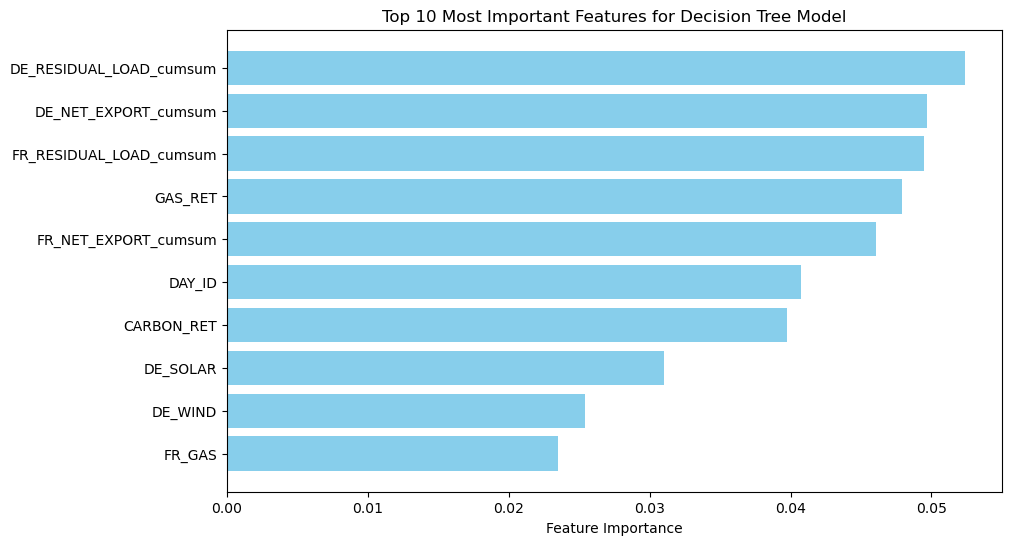

In [70]:
import matplotlib.pyplot as plt

# Assuming 'feature_importance_df' is your DataFrame with feature importances sorted in descending order
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar chart for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features for Decision Tree Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [75]:
X

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,FR_WIND_SQR,DE_WIND_SQR,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_RESIDUAL_LOAD_cumsum,DE_RESIDUAL_LOAD_cumsum,FR_NON_RENEWABLE,FR_RENEWABLE,DE_NON_RENEWABLE,DE_RENEWABLE,EXCESS_PROD_FR,EXCESS_PROD_DE
0,206.0,-0.153169,-0.024349,-0.317882,0.317882,0.747170,0.364807,-0.236271,-0.363153,0.748676,2.044066,1.176167,0.235238,0.764139,0.100129,-0.057919,0.406017,-0.361743,-0.179808,0.998015,0.454808,0.013084,0.067211,-0.491351,-0.444335,-0.072388,-0.856851,0.254140,0.055699,-0.050354,0.0,1.0,-0.083553,0.000000,0.609263,0.262771,0.068397,0.320652,0.309630,0.062073,0.936700,0.370749,0.167443,0.857402
1,501.0,-0.395487,-0.445611,0.070134,-0.070134,-0.216353,-0.743584,-0.446996,0.131324,0.057886,0.008206,-0.089466,-0.455029,-1.691607,-1.353957,0.939921,1.589620,0.041892,-0.074392,-0.005664,-0.524150,-0.610401,-1.064641,-0.798040,1.375466,0.678439,0.414144,-0.513269,-0.014732,-0.485197,0.0,1.0,-0.083553,0.000000,-0.126516,-0.582892,-0.383997,-0.428128,-0.623853,0.711096,-0.547064,0.549790,0.647884,-0.052881
2,687.0,1.081811,1.735408,0.762812,-0.762812,-0.250638,-1.078921,1.274725,1.439705,1.379276,2.989941,-0.275166,0.623781,-1.705218,0.774599,-0.702107,-0.558231,-0.155657,-0.096429,0.581261,1.134777,2.032405,-0.259342,-0.143242,0.517002,0.448238,0.622926,0.405551,0.618495,0.134481,0.0,1.0,-0.083553,0.000000,-0.152697,-0.838742,1.533596,0.840742,1.764679,-0.463958,0.842637,-1.079763,1.357823,-0.214533
3,720.0,-1.396994,-0.332795,-0.472609,0.472609,-0.002418,0.286022,-0.199434,-0.047943,-0.930450,-0.038039,-0.437881,0.991946,-0.102796,-0.919365,0.815087,-0.002293,0.060971,0.233989,-2.019570,-1.286928,-0.436306,-0.931631,-0.421469,-0.215074,-0.040701,0.341182,0.694389,-0.326954,0.908945,1.0,0.0,0.519131,0.000000,0.036852,0.202660,-0.257675,-1.011556,-0.491825,0.669601,-0.991913,0.208618,-0.024410,-0.552880
4,818.0,-0.222260,-0.163001,-0.529307,0.529307,0.522589,0.545598,-0.396447,-0.384065,0.948180,0.951963,-0.351314,-0.447460,0.086633,0.367846,0.255233,0.093327,-0.513012,-0.371662,0.828980,0.402080,-0.055809,-0.323762,-0.302547,-0.678254,-0.564396,0.563408,0.181921,1.330891,2.281802,0.0,1.0,-0.083553,0.000000,0.437765,0.400707,0.018409,0.280322,0.222925,-0.980463,0.680754,-0.540847,-0.749346,0.055438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,809.0,1.221646,1.097669,-1.146945,1.146945,0.034489,0.825235,0.846696,0.873248,0.459851,0.915105,-0.502000,1.256049,0.288263,0.758098,-0.813087,-0.846449,0.025607,1.925768,0.922789,1.337015,0.818618,0.167951,1.580543,0.383014,0.470331,-0.343016,0.667735,0.687783,1.128563,1.0,0.0,1.630782,0.000000,-0.052995,1.286633,0.964992,2.129277,1.055496,1.567892,1.061422,-1.226762,1.130929,-0.264303
1490,887.0,1.314799,1.570247,0.490676,-0.490676,0.506547,-0.148763,0.974899,1.004472,0.612742,1.931640,-0.420804,2.105016,0.298357,0.913881,-0.758834,-0.886932,0.217776,0.508880,1.042454,1.156136,1.795161,0.099057,1.078883,0.578265,0.685097,-0.865296,0.710520,-0.135520,0.269415,0.0,1.0,0.800611,0.555576,0.667965,-0.199616,2.382131,1.852580,1.408042,0.997165,1.215288,-1.009539,1.499406,-0.189720
1491,1083.0,0.520427,0.646063,-0.085026,0.085026,-0.893555,-0.560481,1.082438,1.242254,1.000362,1.135721,-0.183444,0.282703,-1.645309,-0.463962,-0.443420,-0.220241,-0.668189,0.192658,0.376829,1.285380,0.690808,0.470693,0.885398,-0.289959,0.722749,0.261369,-0.862176,-0.273899,0.011672,1.0,0.0,0.464444,0.000000,-1.470366,-0.827868,0.779516,2.050289,0.634463,-0.171986,0.567500,-1.100958,0.606957,-0.052774
1492,1133.0,0.212228,0.036853,-0.466403,0.466403

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


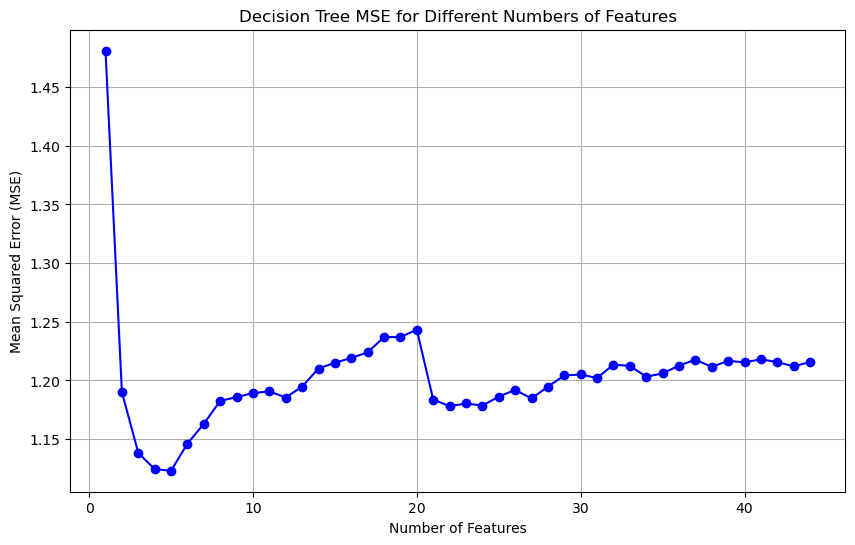

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train_imputed is already defined and contains the imputed training data

# Initialize an empty list to store the mean squared errors for each k number of features
mse_scores_per_k = []

# Initialize the DecisionTreeRegressor
rf = RandomForestRegressor(random_state=42)

# Loop over the range of number of features
for k in range(1, len(X.columns) + 1):
    print(k)
    # Select the top k features based on previously computed feature importances
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    
    # Compute the cross-validated MSE
    mse_scores = cross_val_score(rf, X[selected_features], y, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

# Plot the MSE scores for each number of top features used
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('Decision Tree MSE for Different Numbers of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
import numpy as np

# Assuming 'data_train_imputed' is your DataFrame and includes 'TARGET'
X = data_merged.drop(columns=['TARGET'])
y = data_merged['TARGET']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid_rf = {
    'n_estimators': sp_randint(100, 1000),
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

rs_cv_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,  # Adjust based on computational budget
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
rs_cv_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = rs_cv_rf.best_params_
print("Best Parameters:", best_params_rf)

# Initialize RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# Fit the model on the entire training dataset
best_rf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = best_rf.predict(X_valid)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_rf))
print(f'Validation RMSE: {rmse}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 445}
Validation RMSE: 1.0802746328888033


In [54]:
mse = mean_squared_error(y_valid, y_pred_rf)
mae = mean_absolute_error(y_valid, y_pred_rf)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"The Mean Squared Error is: {mse}")

r2_valid = r2_score(y_valid, y_pred_rf)
print(f'R-squared (R2) on Validation Set: {r2_valid}')


Mean Absolute Error (MAE): 0.5873237724675703
The Mean Squared Error is: 1.166993282463039
R-squared (R2) on Validation Set: 0.022923557981032294


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

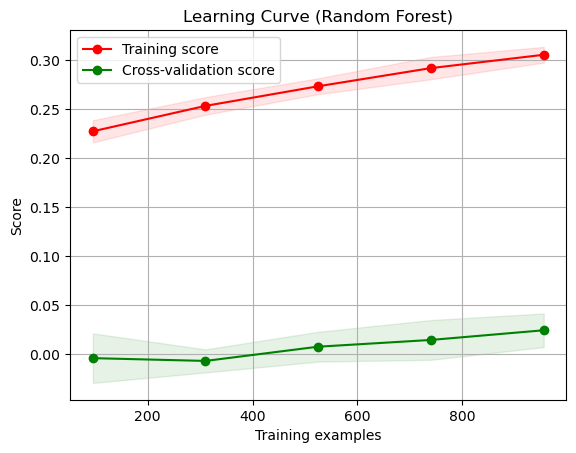

In [56]:
from sklearn.ensemble import RandomForestRegressor

# Assuming best_params_rf contains the best parameters found for RandomForestRegressor from previous steps
best_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Plot learning curve for RandomForestRegressor
title = "Learning Curve (Random Forest)"
plot_learning_curve(best_rf, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()



In [57]:
!pip install catboost


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [58]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

# Assuming best_params_dt contains the best parameters found for the DecisionTreeRegressor
# And best_params_rf contains the best parameters for the RandomForestRegressor

# Instantiate base models with the best parameters
dt_reg_best = DecisionTreeRegressor(**random_search_dt.best_params_)
rf_reg_best = RandomForestRegressor(**best_params_rf)

# Define the base models list
base_models = [
    ('decision_tree_best', dt_reg_best),
    ('random_forest_best', rf_reg_best)
]

# Choose a meta-learner
catboost_meta_learner = CatBoostRegressor(iterations=100, 
                                          learning_rate=0.1, 
                                          depth=2, 
                                          verbose=False, 
                                          random_state=42)

# Initialize the Stacking Regressor
stack_reg = StackingRegressor(estimators=base_models, 
                              final_estimator=catboost_meta_learner, 
                              cv=5)

# Now you can fit the stacking ensemble to your training data and use it for predictions
stack_reg.fit(X_train, y_train)

# And proceed with predictions, evaluation, etc.


NameError: name 'random_search_dt' is not defined

In [ ]:
y_pred = stack_reg.predict(X_valid)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2 score): {r2}")


Mean Absolute Error (MAE): 0.5831277248679256
Mean Squared Error (MSE): 0.8969992916951546
Coefficient of Determination (R^2 score): -0.013401913586384762
